In [1]:
# Install necessary libraries if you haven't already
# !pip install -r requirements.txt

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [4]:
dataset = pd.read_csv(file_name)

In [5]:
dataset.shape

(144, 2)

In [6]:
dataset.columns

Index(['ds', 'y'], dtype='object')

In [7]:
dataset.dtypes

ds    object
y      int64
dtype: object

In [8]:
dataset.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [9]:
time_col = dataset.columns[0]
target_col = dataset.columns[-1]
dataset[time_col] = pd.to_datetime(dataset[time_col])
dataset.set_index(time_col, inplace=True)
dataset.index = dataset.index + pd.offsets.MonthEnd(0)
dataset = dataset.asfreq('M')

In [10]:
target_col

'y'

In [11]:
dataset

,y
ds,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
...,...
1960-08-31,606
1960-09-30,508
1960-10-31,461


<Axes: xlabel='ds'>

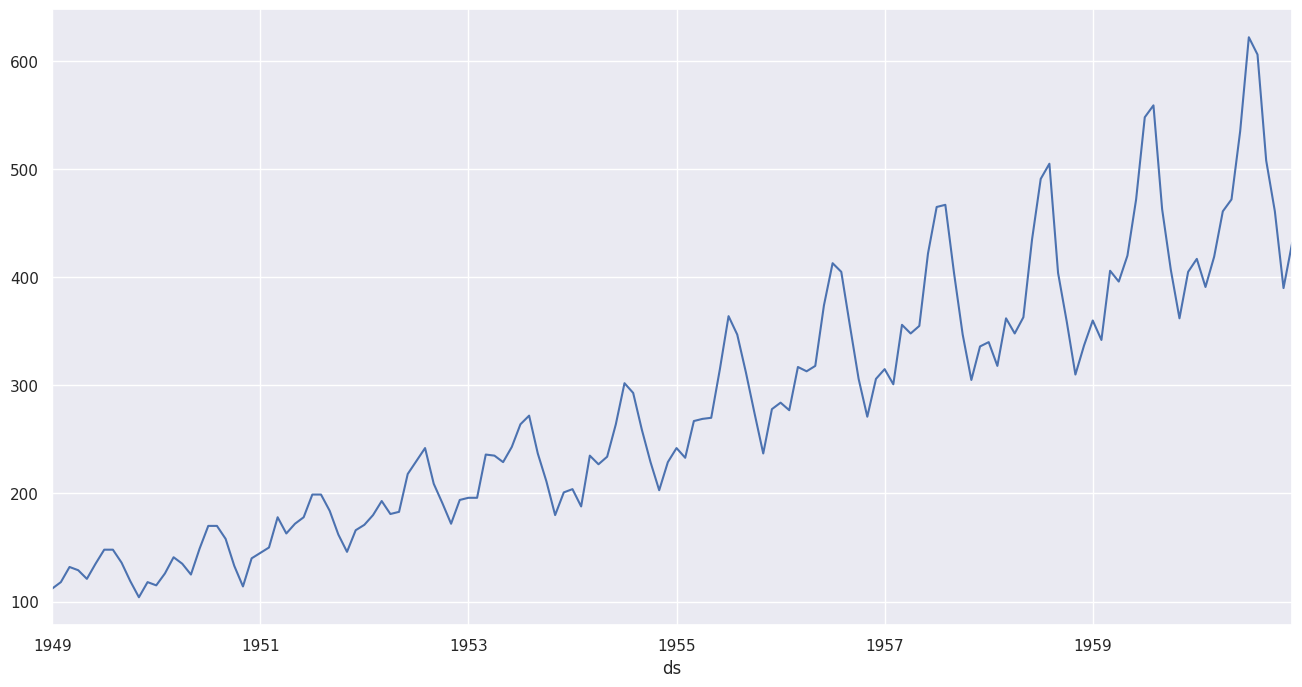

In [12]:
figsize = (16, 8)
dataset[target_col].plot(figsize=figsize)

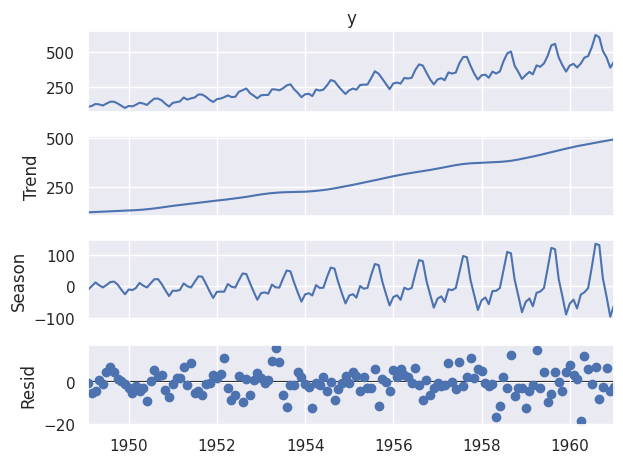

In [13]:
from statsmodels.tsa.seasonal import STL

stl = STL(dataset[target_col], period=12, seasonal=13)
res = stl.fit()
fig = res.plot()

In [14]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
adfuller(res.resid)

(-5.098010977108992,
 1.4148675043445649e-05,
 9,
 134,
 {'1%': -3.480118600110386,
  '5%': -2.8833618426136196,
  '10%': -2.578407034974382},
 822.6458135470642)

In [15]:
# dataset[target_col] = res.resid + res.seasonal
dataset[target_col] = res.resid
seasonality = res.seasonal
trend = res.trend

In [16]:
train_size = 0.8
train_points = int(train_size*len(dataset))
train_df = dataset.iloc[:train_points]
test_df = dataset.iloc[train_points:]

In [17]:
train_points = int(train_size*len(train_df)) #further split train dataset to train and calibration
cal_df = train_df.iloc[train_points:]
train_df = train_df.iloc[:train_points]

In [18]:
df_dict = {'train': train_df, 'calibration': cal_df, 'test': test_df}
for key, value in df_dict.items():
    print(f'{key} dataframe shape: {value.shape}')

train dataframe shape: (92, 1)
calibration dataframe shape: (23, 1)
test dataframe shape: (29, 1)


### **Base model fitting (prior to fit mauq)**

In [19]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
y_train = train_df[target_col]
y_cal = cal_df[target_col]
y_test = test_df[target_col]

fh_cal = ForecastingHorizon(pd.date_range(start=y_train.index[-1], periods=len(y_cal)+1, freq='M')[1:], is_relative=False)
fh_test = ForecastingHorizon(pd.date_range(start=y_cal.index[-1], periods=len(y_test)+1, freq='M')[1:], is_relative=False)
# forecaster = AutoARIMA(sp=12, seasonal=True)
forecaster = AutoARIMA(seasonal=False, stationary=True)
forecaster.fit(y_train)

/home/kevin/.conda/envs/sybil/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/kevin/.conda/envs/sybil/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/kevin/.conda/envs/sybil/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/kevin/.conda/envs/sybil/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible s

AutoARIMA(seasonal=False, stationary=True)

In [20]:
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.forecasting.stl import STLForecast

# elec_equip.index.freq = elec_equip.index.inferred_freq
# stlf = STLForecast(elec_equip, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"))
# stlf_res = stlf.fit()

# forecast = stlf_res.forecast(24)
# plt.plot(elec_equip)
# plt.plot(forecast)
# plt.show()

In [21]:
y_pred_cal = forecaster.predict(fh_cal)
y_pred_test = forecaster.predict(fh_test)

In [22]:
#data input calibration set
cal_trend = trend.loc[cal_df.index]
cal_seasonal = seasonality.loc[cal_df.index]
# cal_df[target_col] += cal_trend
cal_df[target_col] += cal_trend + cal_seasonal
input_data_cal = cal_df.copy()
# input_data_cal['y_pred'] = y_pred_cal + cal_trend
input_data_cal['y_pred'] = y_pred_cal + cal_trend + cal_seasonal
input_data_cal

,y,y_pred
ds,,
1956-09-30,355.0,351.903969
1956-10-31,306.0,311.873622
1956-11-30,271.0,273.607613
1956-12-31,306.0,306.189725
1957-01-31,315.0,317.026721
1957-02-28,301.0,302.542218
1957-03-31,356.0,346.996170
1957-04-30,348.0,347.924560
1957-05-31,355.0,358.216534


In [23]:
#data input test set (optional)
test_trend = trend.loc[test_df.index]
test_seasonal = seasonality.loc[test_df.index]
# test_df[target_col] += test_trend
test_df[target_col] += test_trend + test_seasonal
input_data_test = test_df.copy()
# input_data_test['y_pred'] = y_pred_test + test_trend
input_data_test['y_pred'] = y_pred_test + test_trend + test_seasonal
input_data_test

/tmp/ipykernel_608149/2205505766.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target_col] += test_trend + test_seasonal


,y,y_pred
ds,,
1958-08-31,505.0,491.863957
1958-09-30,404.0,410.569162
1958-10-31,359.0,361.584717
1958-11-30,310.0,312.611600
1958-12-31,337.0,349.601888
1959-01-31,360.0,364.237937
1959-02-28,342.0,343.238255
1959-03-31,406.0,390.740917
1959-04-30,396.0,398.955284


In [24]:
#data input train set (optional)
train_trend = trend.loc[train_df.index]
train_seasonal = seasonality.loc[train_df.index]
# train_df[target_col] += train_trend
train_df[target_col] += train_trend + train_seasonal
input_data_train = train_df.copy()
input_data_train

,y
ds,
1949-01-31,112.0
1949-02-28,118.0
1949-03-31,132.0
1949-04-30,129.0
1949-05-31,121.0
...,...
1956-04-30,313.0
1956-05-31,318.0
1956-06-30,374.0


### **MAUQ Quantify Uncertainty API**

In [25]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [26]:
user_value = 0.9
output_type = 'data'  # 'data', 'estimate'

In [27]:
api_json = {
    'data': input_data_cal.values.tolist(),
    'test': input_data_test.values.tolist(),
    'train': input_data_train.values.tolist(),
    'problem_type': 'regression',
    'proba_type': 'interval',
    'confidence_level': user_value,
    'num_bins': None,
    'output_type': output_type
}

In [28]:
# URL to our MAUQ AWS service
protocol = url_dict['protocol']  # protocol not sybil_protocol
host = url_dict['host']
port = url_dict['port']
endpoint = 'quantify-uncertainty'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [29]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 42.8 ms, sys: 829 µs, total: 43.6 ms
Wall time: 141 ms


In [30]:
uncertainty_json_out = response.json()
# uncertainty_json_out

In [31]:
uncertainty_cols = list(input_data_test.columns) + ['lower_interval', 'upper_interval']
uncertainty_df = pd.DataFrame(uncertainty_json_out['output'], columns=uncertainty_cols).set_index(input_data_test.index)

In [32]:
uncertainty_df

,y,y_pred,lower_interval,upper_interval
ds,,,,
1958-08-31,505.0,491.863957,480.895546,502.832368
1958-09-30,404.0,410.569162,399.600750,421.537573
1958-10-31,359.0,361.584717,350.616306,372.553129
1958-11-30,310.0,312.611600,301.643189,323.580011
1958-12-31,337.0,349.601888,338.633477,360.570300
1959-01-31,360.0,364.237937,353.269526,375.206348
1959-02-28,342.0,343.238255,332.269844,354.206667
1959-03-31,406.0,390.740917,379.772505,401.709328
1959-04-30,396.0,398.955284,387.986873,409.923696


<Axes: xlabel='ds'>

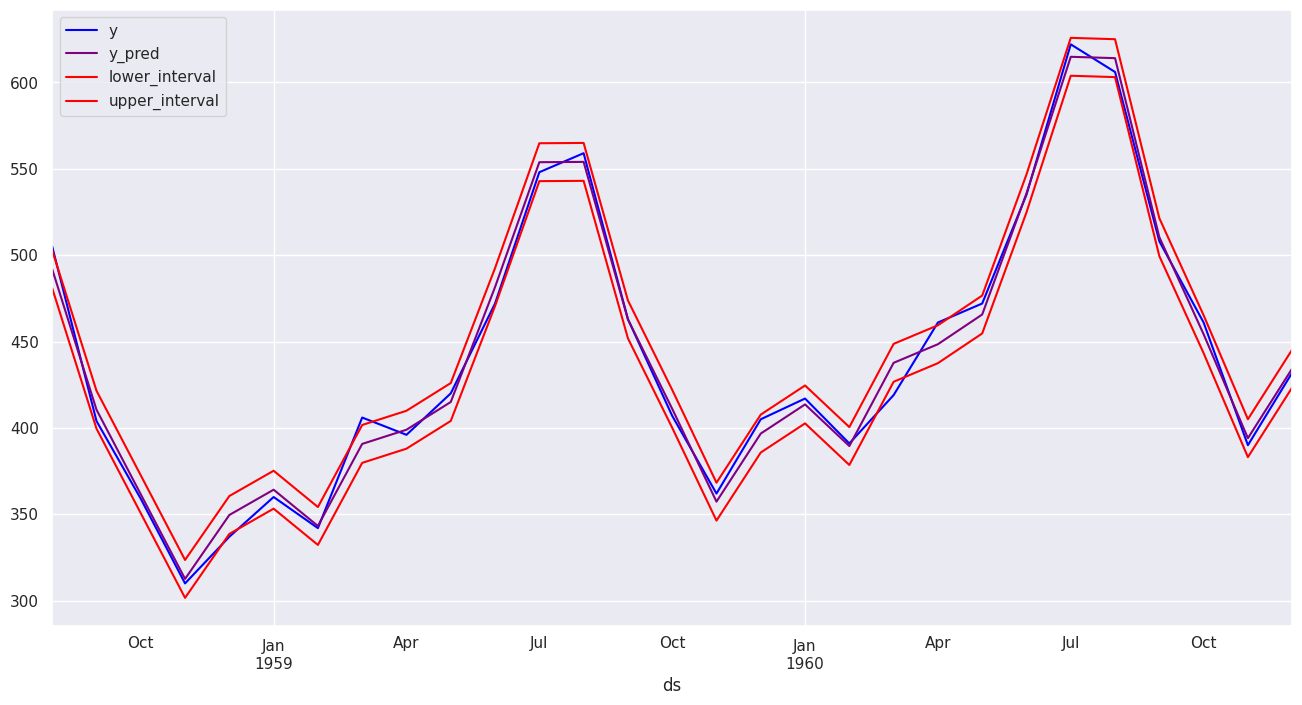

In [33]:
uncertainty_colors = ['blue', 'purple', 'red', 'red']
uncertainty_df.iloc[:, -4:].plot(figsize=figsize, color=uncertainty_colors)

In [34]:
coverage = (uncertainty_df['y']>=uncertainty_df['lower_interval'])&(uncertainty_df['y']<=uncertainty_df['upper_interval'])
coverage.sum()/len(coverage)

0.8275862068965517

In [35]:
df = pd.concat([train_df, cal_df, uncertainty_df]).reset_index()
df

,ds,y,y_pred,lower_interval,upper_interval
0,1949-01-31,112.0,NaN,NaN,NaN
1,1949-02-28,118.0,NaN,NaN,NaN
2,1949-03-31,132.0,NaN,NaN,NaN
3,1949-04-30,129.0,NaN,NaN,NaN
4,1949-05-31,121.0,NaN,NaN,NaN
...,...,...,...,...,...
139,1960-08-31,606.0,614.008212,603.039801,624.976624
140,1960-09-30,508.0,510.401357,499.432946,521.369768
141,1960-10-31,461.0,454.217738,443.249327,465.186149
142,1960-11-30,390.0,394.053148,383.084736,405.021559


In [36]:
uncertainty_df.reset_index(inplace=True)
uncertainty_df

,ds,y,y_pred,lower_interval,upper_interval
0,1958-08-31,505.0,491.863957,480.895546,502.832368
1,1958-09-30,404.0,410.569162,399.600750,421.537573
2,1958-10-31,359.0,361.584717,350.616306,372.553129
3,1958-11-30,310.0,312.611600,301.643189,323.580011
4,1958-12-31,337.0,349.601888,338.633477,360.570300
5,1959-01-31,360.0,364.237937,353.269526,375.206348
6,1959-02-28,342.0,343.238255,332.269844,354.206667
7,1959-03-31,406.0,390.740917,379.772505,401.709328
8,1959-04-30,396.0,398.955284,387.986873,409.923696
9,1959-05-31,420.0,415.002028,404.033617,425.970440


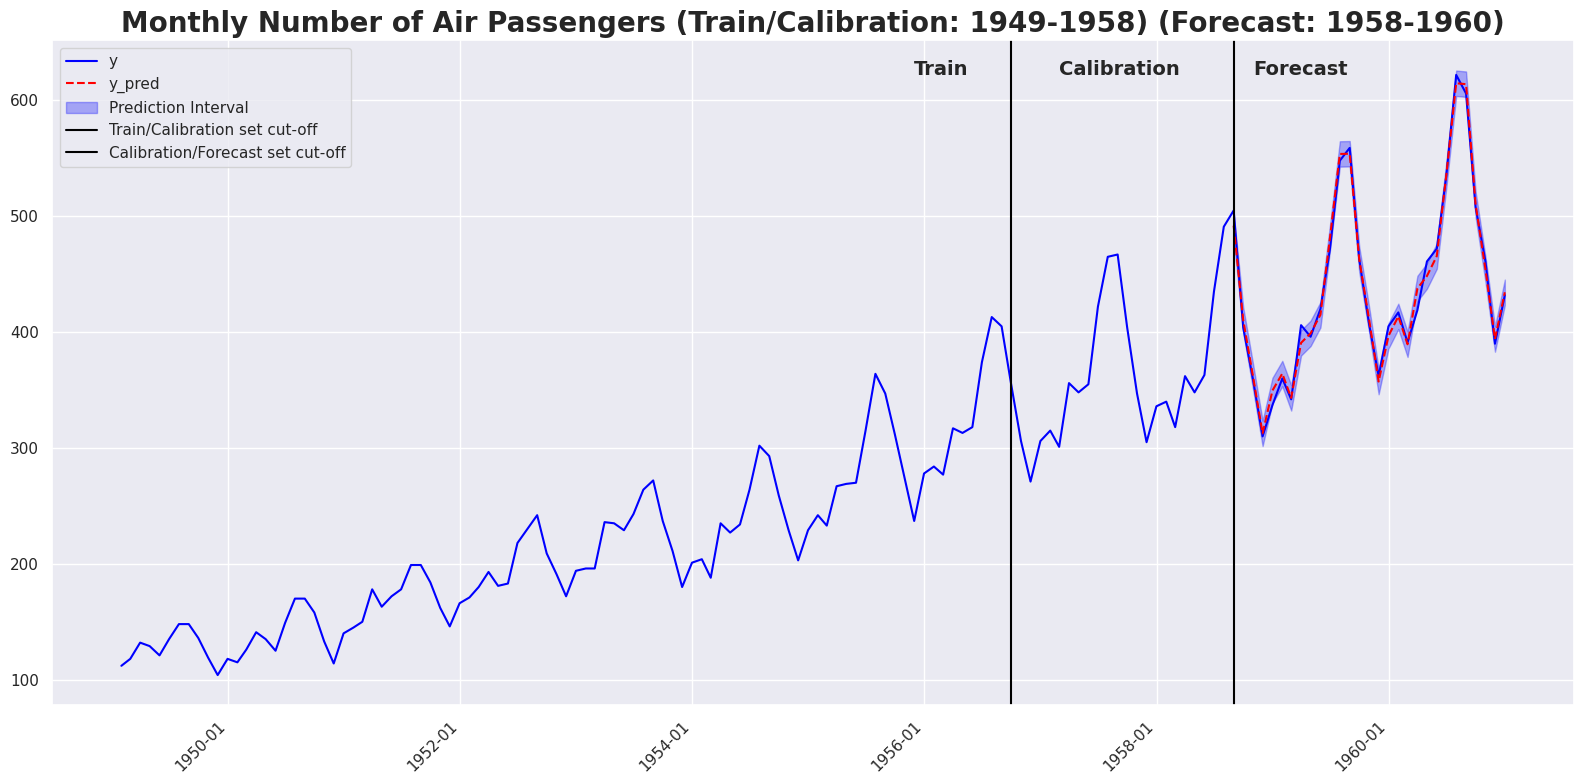

In [37]:
plt.figure(figsize=figsize)

plt.plot(df[time_col], df[target_col], color='blue', label='y')
plt.plot(uncertainty_df[time_col], uncertainty_df['y_pred'], color='red', linestyle='dashed', label='y_pred')
plt.fill_between(uncertainty_df[time_col], uncertainty_df['lower_interval'], uncertainty_df['upper_interval'], 
                 color='blue', alpha=0.3, label='Prediction Interval')
plt.axvline(x=df[time_col].iloc[len(train_df)], color='black', label='Train/Calibration set cut-off')
plt.axvline(x=df[time_col].iloc[len(train_df)+len(cal_df)], color='black', label='Calibration/Forecast set cut-off')

plt.text(df[time_col].iloc[len(train_df)-10], df[target_col].max(), 'Train', fontweight='bold', fontsize=14)
plt.text(df[time_col].iloc[len(train_df)+5], df[target_col].max(), 'Calibration', fontweight='bold', fontsize=14)
plt.text(df[time_col].iloc[len(train_df)+25], df[target_col].max(), 'Forecast', fontweight='bold', fontsize=14)

plt.title('Monthly Number of Air Passengers (Train/Calibration: 1949-1958) (Forecast: 1958-1960)', fontweight='bold', fontsize=20)
plt.legend()

ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right") 
plt.tight_layout()
plt.show()